# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the ERA5 and CarbonTracker data, to be able to train a ML model.

First download the CarbonTracker and monthly ERA5 data using the instructions in the README file.

The functions written to process the data are contained in `src/carbontracker.py`. We can import them with:

In [1]:
from src import carbontracker, modis
from pathlib import Path
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with ERA5 data.

In [2]:
data_folder = Path("/home/yangliu/Excited/EXCITED_prepped_data")
ds_cb = xr.open_dataset(data_folder / "CT2022.flux1x1-monthly.nc")
ds_cb = carbontracker.convert_ct_timestamps(ds_cb)

/home/yangliu/venv/excited/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Next we load in the monthly ERA5 data. We will have to convert the latitude values to be formatted (-180 -> 180 degrees) instead of (0 -> 360 degrees).

Next we coarsen the data to a 1-degree grid, centered around the half values (e.g., [0.5, 1.5, ...]).

In [3]:
ds_era5 = xr.open_mfdataset("/home/yangliu/Excited/EXCITED_prepped_data/monthly_era5/*.nc")
ds_era5 = carbontracker.shift_era5_longitude(ds_era5)
ds_era5 = carbontracker.coarsen_era5(ds_era5)

Now we also include variables (e.g. NIRv) from MODIS dataset.

In [4]:
ds_modis = modis.load_modis_data(data_folder / "modis")

In [5]:
# regrid modis dataset to era5 grid
ds_modis_regrid = ds_modis.regrid.regrid(ds_era5, method="linear")
ds_modis_regrid

<xarray.Dataset>
Dimensions:    (time: 274, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-01 2000-04-01 ... 2022-12-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    NDVI       (time, latitude, longitude) float32 dask.array<chunksize=(274, 180, 360), meta=np.ndarray>
    NIRv       (time, latitude, longitude) float32 dask.array<chunksize=(274, 180, 360), meta=np.ndarray>
Attributes:
    author:         Gerbrand Koren (gerbrand.koren@wur.nl)
    creation_date:  2020-02-21 22:01:20
    version:        v0.1

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [6]:
ds_regions = xr.open_dataset(data_folder / "regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge all three datasets together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [7]:
ds_merged = xr.merge([ds_cb[["bio_flux_opt"]], ds_regions["transcom_regions"],
                      ds_era5, ds_modis_regrid["NIRv"]])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [8]:
time_region_na = {
    "time": slice("2011-01", "2020-12"),
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(time_region_na)

In [9]:
ds_na

<xarray.Dataset>
Dimensions:           (longitude: 85, latitude: 45, time: 120)
Coordinates:
  * longitude         (longitude) float64 -139.5 -138.5 -137.5 ... -56.5 -55.5
  * latitude          (latitude) float64 15.5 16.5 17.5 18.5 ... 57.5 58.5 59.5
  * time              (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2020-12-01
Data variables: (12/13)
    bio_flux_opt      (time, latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    transcom_regions  (latitude, longitude) float64 ...
    d2m               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    mslhf             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    msshf             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    sp                (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    ...                ...
    str               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    t2m               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    tp                (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    tvh               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    tvl               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    NIRv              (time, latitude, longitude) float32 dask.array<chunksize=(120, 45, 85), meta=np.ndarray>
Attributes:
    averaging_period_length_hours:  744
    email:                          carbontracker.team@noaa.gov
    url:                            http://carbontracker.noaa.gov
    institution:                    NOAA Earth System Research Laboratory
    Conventions:                    CF-1.5
    history:                        Time-stamp: <Orion-login-1.HPC.MsState.Ed...
    NCO:                            netCDF Operators version 4.9.3 (Homepage ...
    version:                        CT2022 1x1 3-hourly fluxes as of 2023-01-...

We can now compute the dataset (instead of leaving it lazy and out-of-memory), as it is small enough to fit into RAM.
This operation should not take more than 1 or 2 minutes.

In [10]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

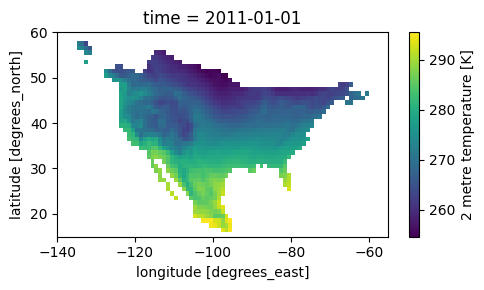

In [11]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["t2m"].isel(time=0).plot()
plt.tight_layout()

To prepare the data for training, we convert it to a Pandas `DataFrame`.

We will remove all rows with NaN values, and unset the indices:

In [12]:
df_train = ds_na.to_dataframe().dropna().reset_index()
df_train.head(3)

,time,latitude,longitude,bio_flux_opt,transcom_regions,d2m,mslhf,msshf,sp,ssr,str,t2m,tp,tvh,tvl,NIRv
0,2011-01-01,16.5,-97.5,-5.227481e-07,2.0,285.565155,-29.651846,-81.734573,89629.320312,17326388.0,-7365972.0,293.652771,0.000123,13.320068,5.240015,0.127976
1,2011-01-01,16.5,-96.5,-1.711346e-07,2.0,282.666077,-25.926147,-86.677773,84901.765625,16953492.0,-7270913.0,290.940460,0.000244,9.080024,5.600026,0.092293
2,2011-01-01,16.5,-95.5,-4.372959e-08,2.0,288.643372,-59.082165,-74.887657,94552.640625,16264480.0,-5862043.5,294.855896,0.000636,7.160083,5.520013,0.108840


Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

In [13]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)# normalize=True, normalize_method="robust")
best = pycs.compare_models(n_select=5, round=2)

/tmp/ipykernel_8897/2172964924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.


,Description,Value
0,Session id,7173
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(14316, 7)"
4,Transformed data shape,"(14316, 7)"
5,Transformed train set shape,"(10021, 7)"
6,Transformed test set shape,"(4295, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.40,0.38,0.62,0.63,0.27,19.26,0.76
rf,Random Forest Regressor,0.40,0.39,0.62,0.62,0.27,21.10,2.07
lightgbm,Light Gradient Boosting Machine,0.40,0.39,0.63,0.62,0.28,22.22,0.24
gbr,Gradient Boosting Regressor,0.42,0.42,0.65,0.60,0.28,24.45,0.80
lr,Linear Regression,0.51,0.56,0.75,0.47,0.33,25.18,0.49
ridge,Ridge Regression,0.51,0.56,0.75,0.47,0.33,25.07,0.02
lar,Least Angle Regression,0.51,0.56,0.75,0.47,0.33,25.09,0.02
br,Bayesian Ridge,0.51,0.56,0.75,0.47,0.33,24.51,0.02
en,Elastic Net,0.51,0.57,0.75,0.45,0.33,28.27,0.03
llar,Lasso Least Angle Regression,0.51,0.58,0.76,0.45,0.33,28.38,0.03
